In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from matplotlib.colors import LogNorm

import os


In [2]:
cosmic = pd.read_csv('../data/raw/cosmic.csv.gz')
cosmic.head()

,Channel,ADC_ADC_Sig,ADC_ADC_bg,Board,Nhit,Asic_TDC0,Asic_ADC0,Asic_TOT0,Asic_TDC1,Asic_ADC1,...,Asic_TOT4,Asic_TDC5,Asic_ADC5,Asic_TOT5,Asic_TDC6,Asic_ADC6,Asic_TOT6,Asic_TDC7,Asic_ADC7,Asic_TOT7
0,41,56,0,3,1,-1,-1,-1,4884,56,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,14,83,0,15,1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,4863,83,6,-1,-1,-1
2,15,43,0,34,1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,4817,43,7
3,12,110,0,35,1,-1,-1,-1,-1,-1,...,7,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,12,224,0,56,1,-1,-1,-1,-1,-1,...,7,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [3]:
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.compose import ColumnTransformer

leave_cols = ['Channel', 'Board', 'Nhit']
special_cols = ['ADC_ADC_bg']
scale_cols = [ 'ADC_ADC_Sig', 'Asic_TDC0',
              'Asic_ADC0', 'Asic_TOT0', 'Asic_TDC1', 'Asic_ADC1', 'Asic_TOT1',
              'Asic_TDC2', 'Asic_ADC2', 'Asic_TOT2', 'Asic_TDC3', 'Asic_ADC3',
              'Asic_TOT3', 'Asic_TDC4', 'Asic_ADC4', 'Asic_TOT4', 'Asic_TDC5',
              'Asic_ADC5', 'Asic_TOT5', 'Asic_TDC6', 'Asic_ADC6', 'Asic_TOT6',
              'Asic_TDC7', 'Asic_ADC7', 'Asic_TOT7']

scaler = QuantileTransformer(n_quantiles=10000, output_distribution='normal', subsample=1000000, random_state=42)
special_scaler = RobustScaler(quantile_range=(5.0, 99.9999))
# context: Channel, Board, ADC_ADC_Sig, 'Nhit', 'ADC_ADC_bg', ['Asic_ADC{i}', f'Asic_TDC{i}', f'Asic_TOT{i}']

def transform(scaler, data, fit=False):
    data_cols = data.columns
    data_leave = data.loc[:, leave_cols]
    data_scale = data.loc[:, scale_cols]
    data_special = data.loc[:, special_cols]
    
    # scale
    data_scale[data_scale == -1] = np.nan
    if fit:
        data_scale = special_scaler.fit_transform(data_scale)
    else:
        data_scale = special_scaler.transform(data_scale)
    data_scale[np.isnan(data_scale)] = -1

    # special
    data_special[data_special == 0] = np.nan
    if fit:
        data_special = scaler.fit_transform(data_special)
    else:
        data_special = scaler.transform(data_special)
    data_special[np.isnan(data_special)] = -1 # was 0 became -1
    
    data = pd.DataFrame(np.column_stack([data_scale, data_special, data_leave]),
                        columns=scale_cols + special_cols + leave_cols)
    return data[list(data_cols)]
    
def inverse_transform(scaler, data):
    data_cols = data.columns
    data_leave = data.loc[:, leave_cols]
    data_scale = data.loc[:, scale_cols]
    data_special = data.loc[:, special_cols]

    data_scale[np.isclose(data_scale, -1, rtol=1e-02)] = np.nan
    data_scale = scaler.inverse_transform(data_scale)    
    data_scale[np.isnan(data_scale)] = -1
 
    data_special[np.isclose(data_special, -1, rtol=1e-02)] = np.nan # was 0 became -1
    data_special = special_scaler.inverse_transform(data_special)    
    data_special[np.isnan(data_special)] = 0

    
    data = pd.DataFrame(np.column_stack([data_scale, data_special, data_leave]),
                        columns=scale_cols + special_cols + leave_cols)
    return data[list(data_cols)]


In [4]:
scaled_cosmic = transform(scaler, cosmic, fit=True)


In [5]:
def plot_ignore(data, scaled_data, nohit=-1, name='noname', bins=50):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.title(f"{name}, without scaling")
    plt.grid()
    plt.hist(data, bins=bins, alpha=0.6, density=True)
    plt.subplot(2, 2, 2)
    plt.title(f"{name}, without scaling, only hits")
    plt.grid()
    plt.hist(data[data != nohit], bins=bins, alpha=0.6, density=True)
    plt.subplot(2, 2, 3)
    plt.title(f"{name}, with scaling")
    plt.grid()
    plt.hist(scaled_data, bins=bins, alpha=0.6, density=True)
    plt.subplot(2, 2, 4)
    plt.title(f"{name}, with scaling, only hits")
    plt.grid()
    plt.hist(scaled_data[scaled_data != nohit], bins=bins, alpha=0.6, density=True)

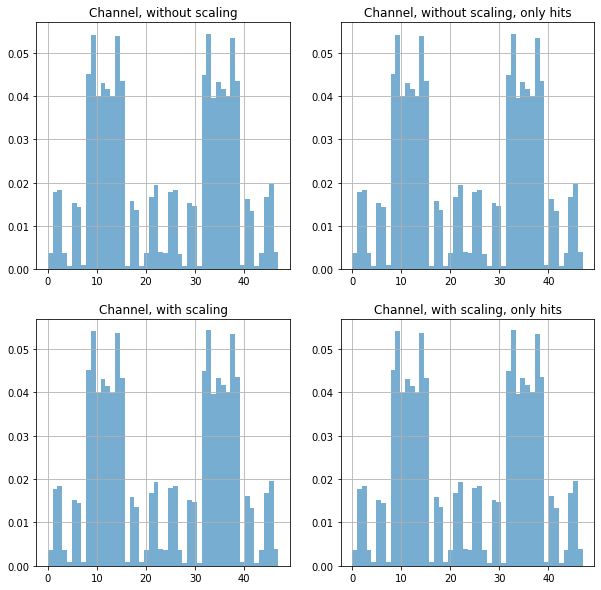

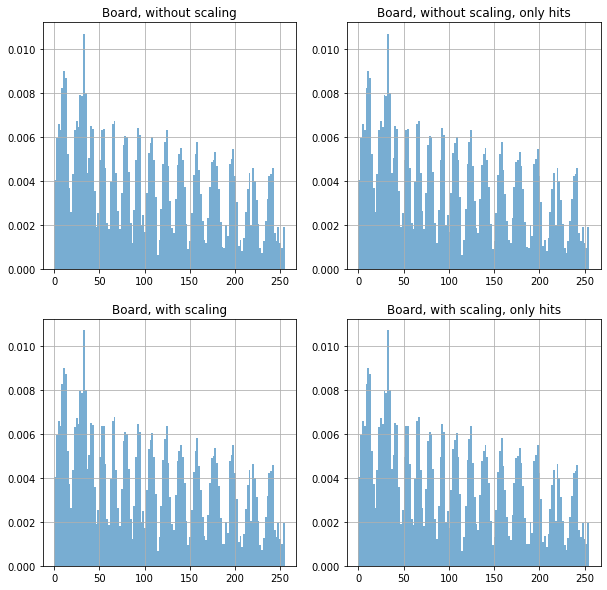

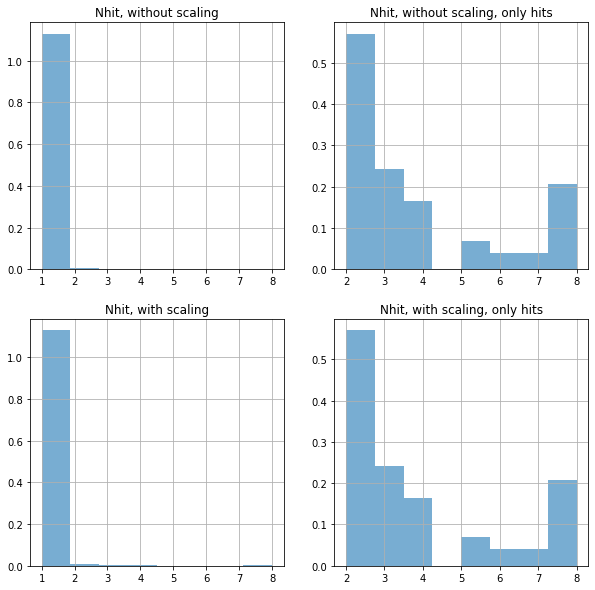

In [6]:
col = 'Channel'
plot_ignore(cosmic[col], scaled_cosmic[col], nohit=-1, name=col, bins=48)
plt.show()

col = 'Board'
plot_ignore(cosmic[col], scaled_cosmic[col], nohit=-1, name=col, bins=256//2)
plt.show()

col = 'Nhit'
plot_ignore(cosmic[col], scaled_cosmic[col], nohit=1, name=col, bins=8)
plt.show()


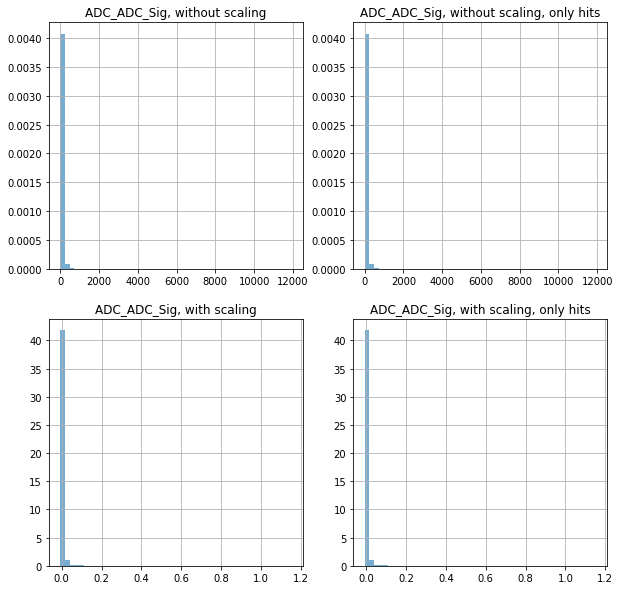

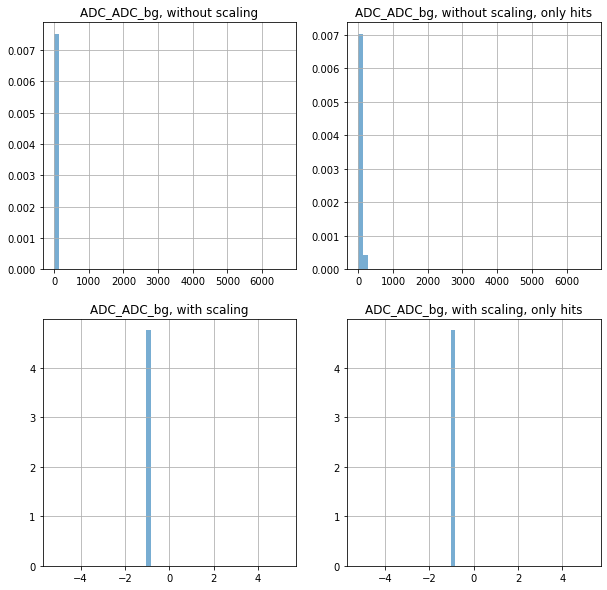

In [7]:
col = 'ADC_ADC_Sig'
plot_ignore(cosmic[col], scaled_cosmic[col], nohit=0, name=col, bins=50)
plt.show()

col = 'ADC_ADC_bg'
plot_ignore(cosmic[col], scaled_cosmic[col], nohit=0, name=col, bins=50)
plt.show()


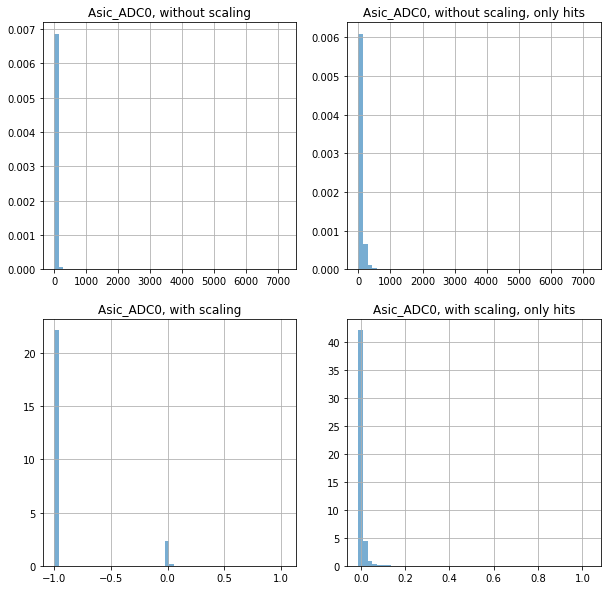

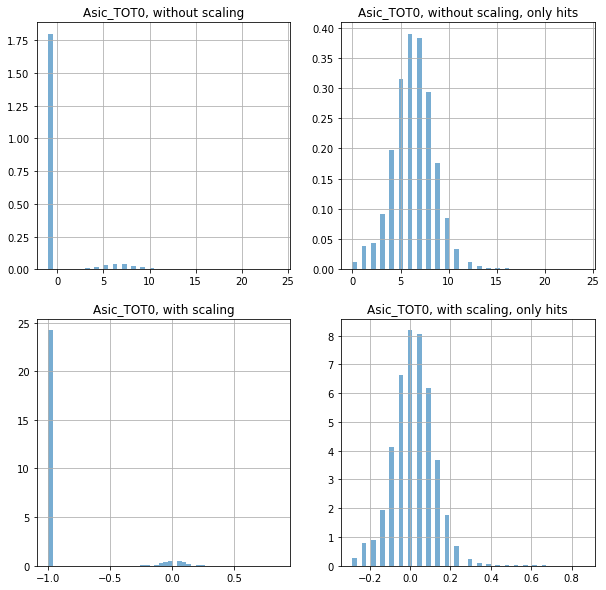

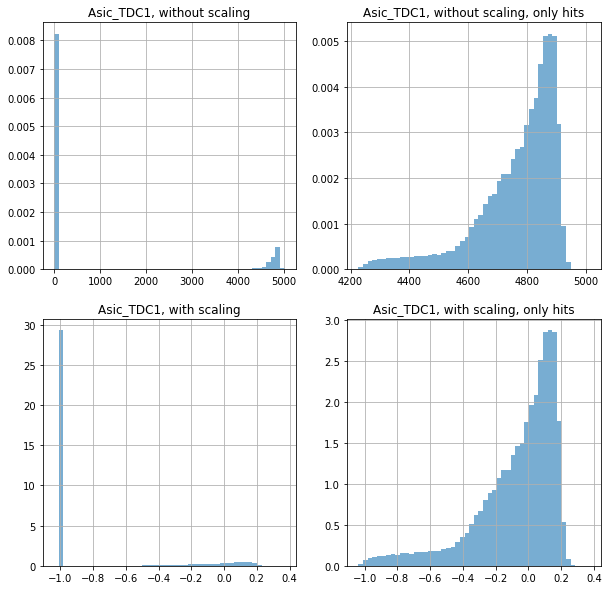

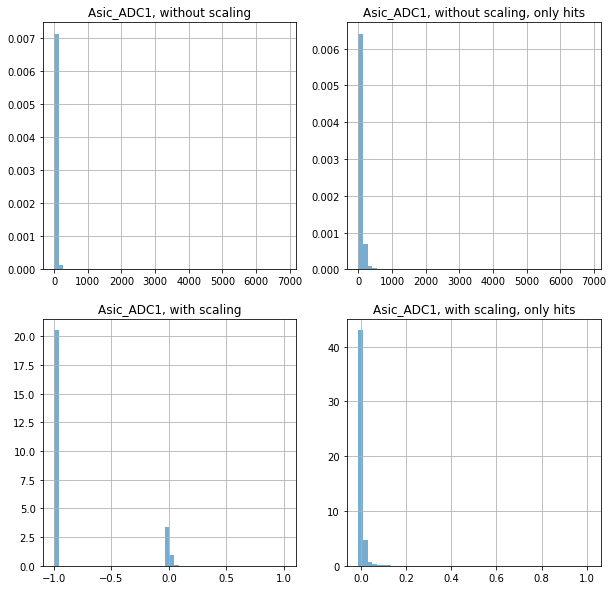

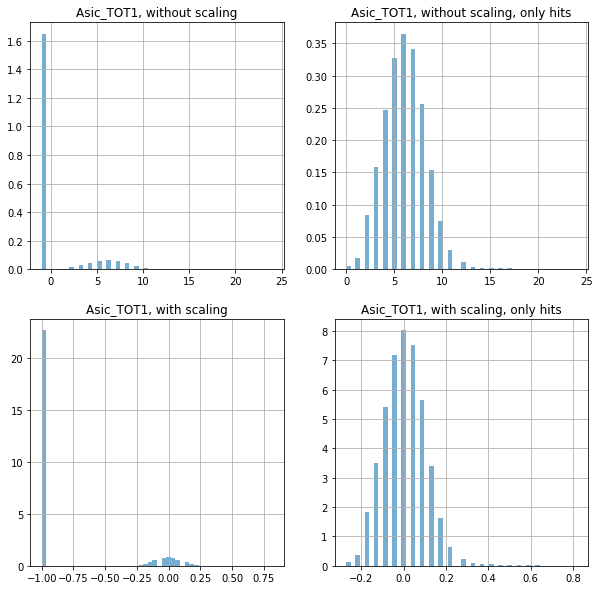

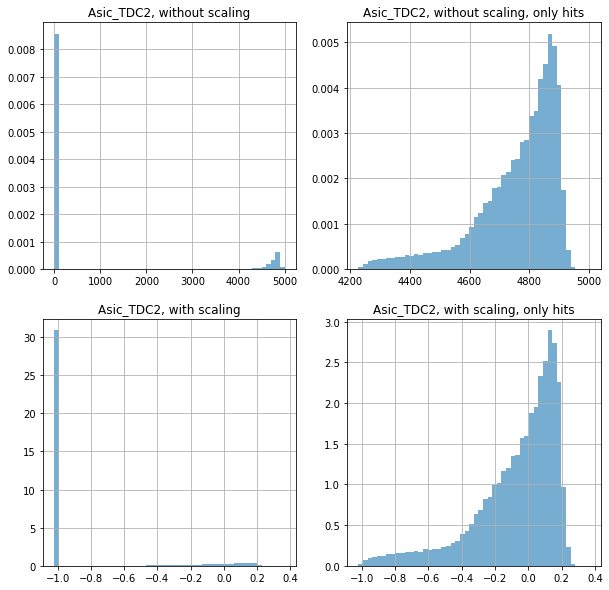

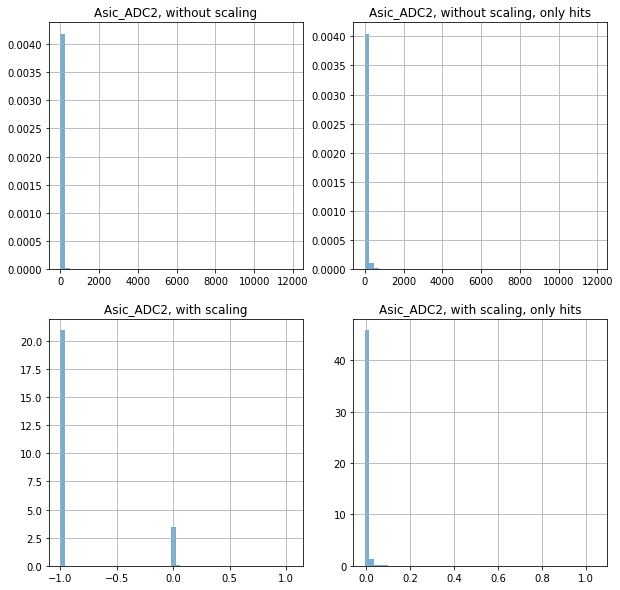

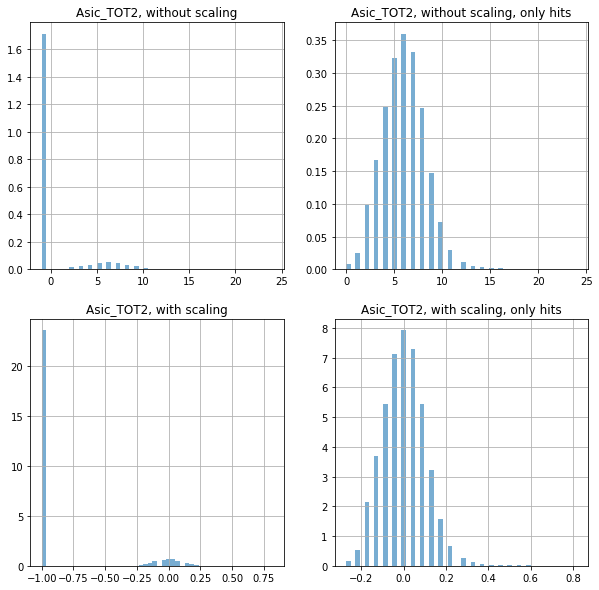

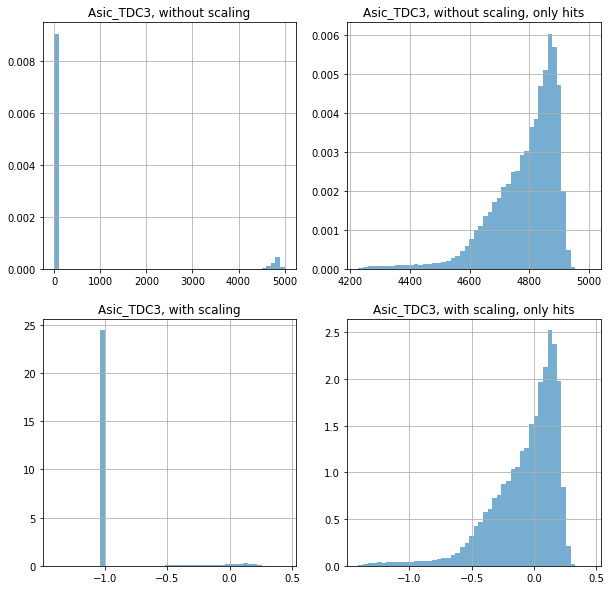

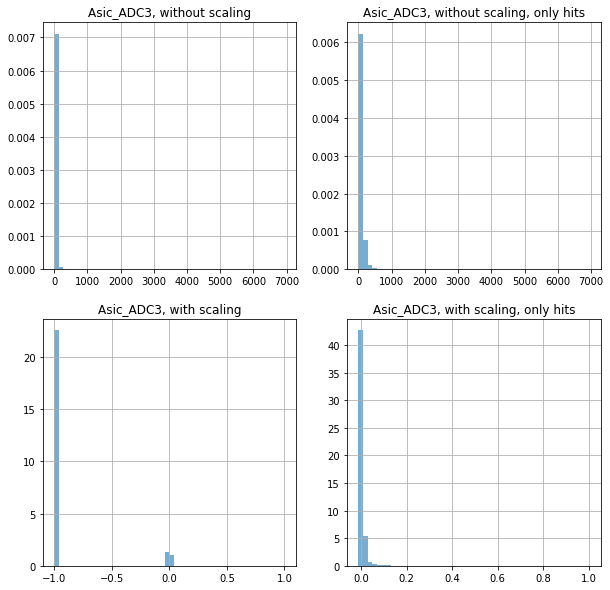

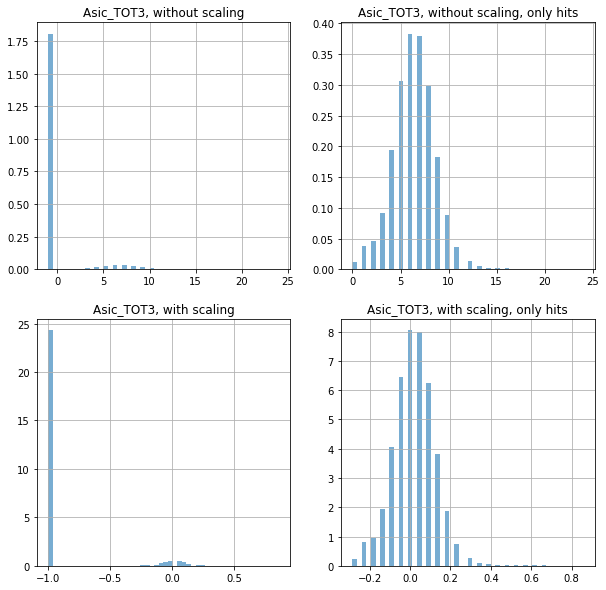

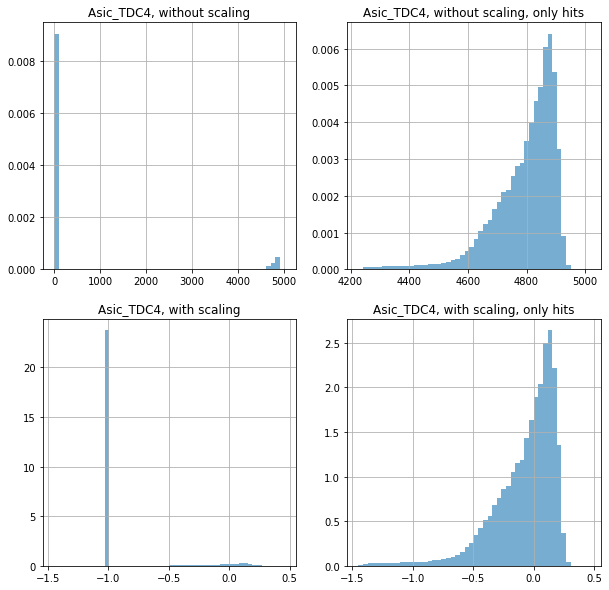

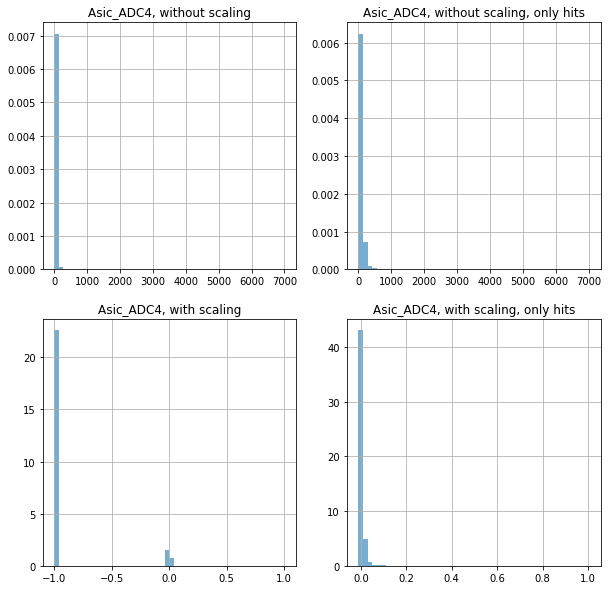

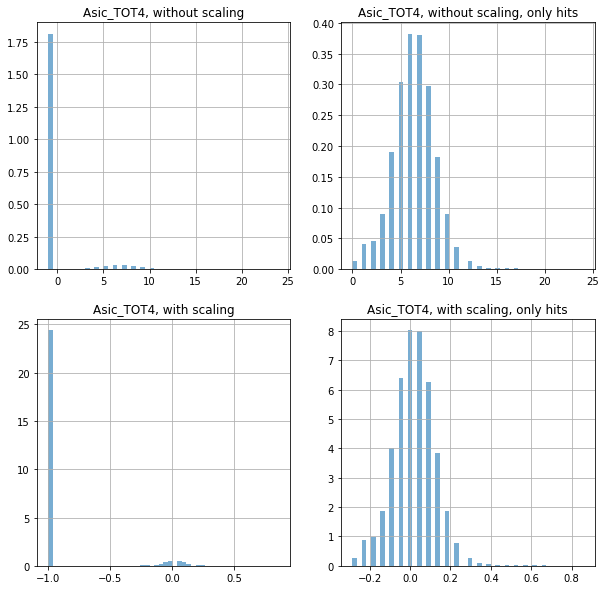

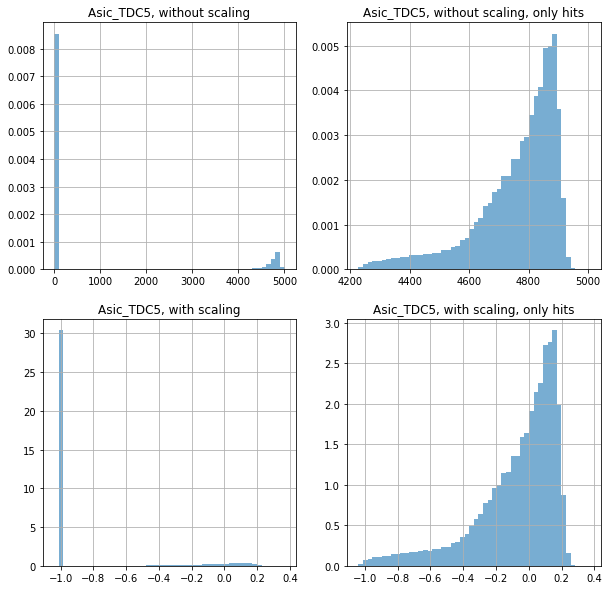

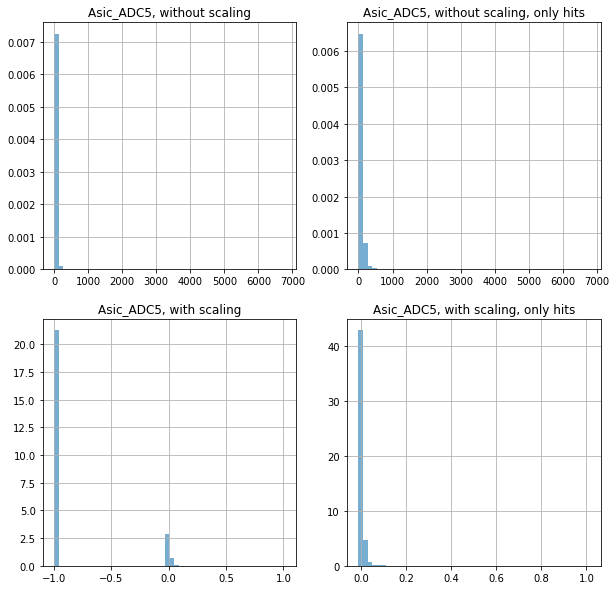

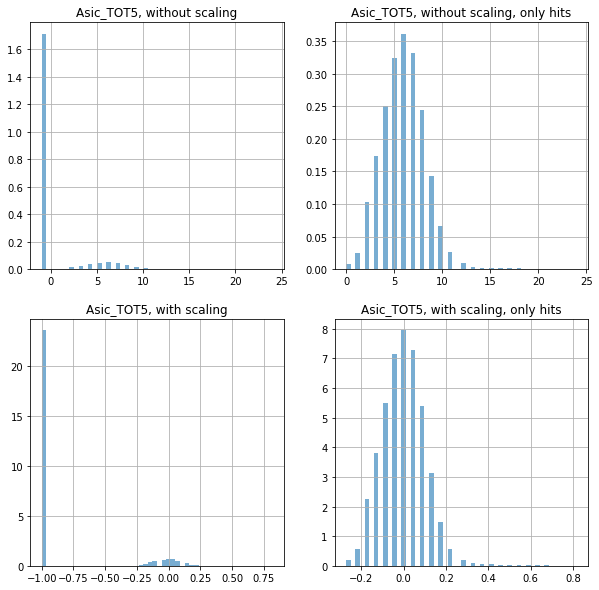

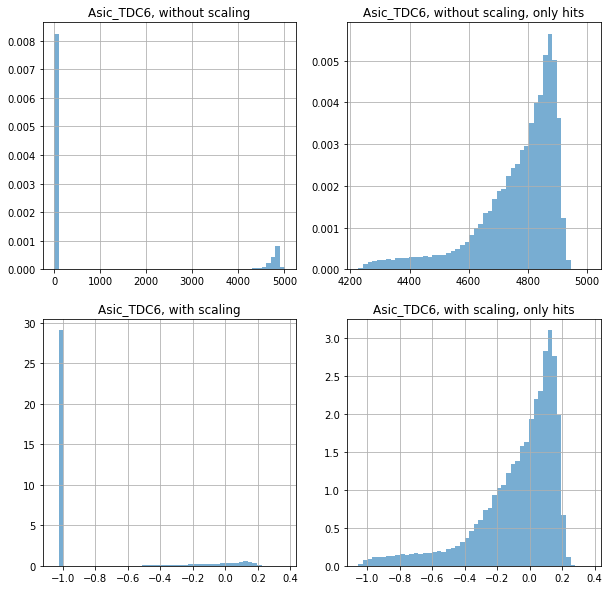

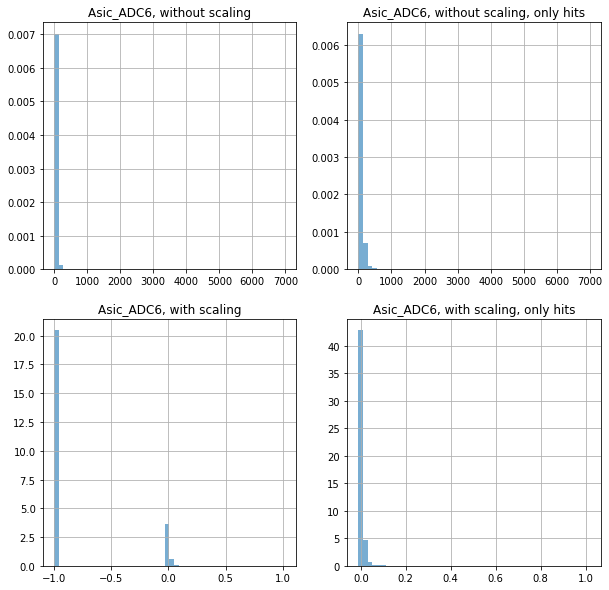

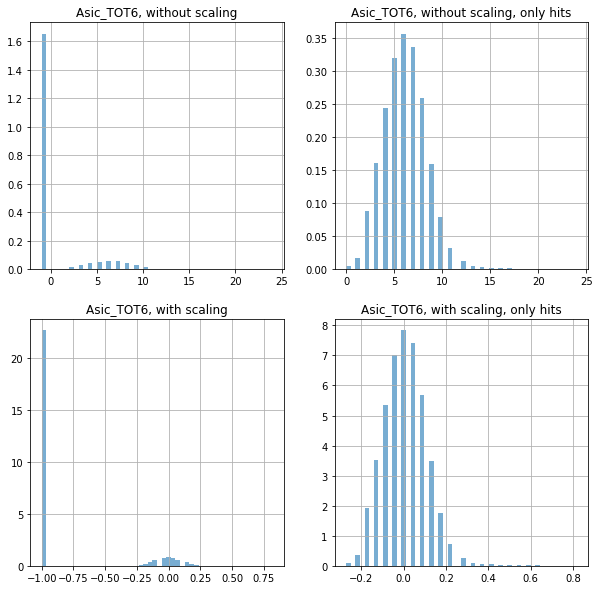

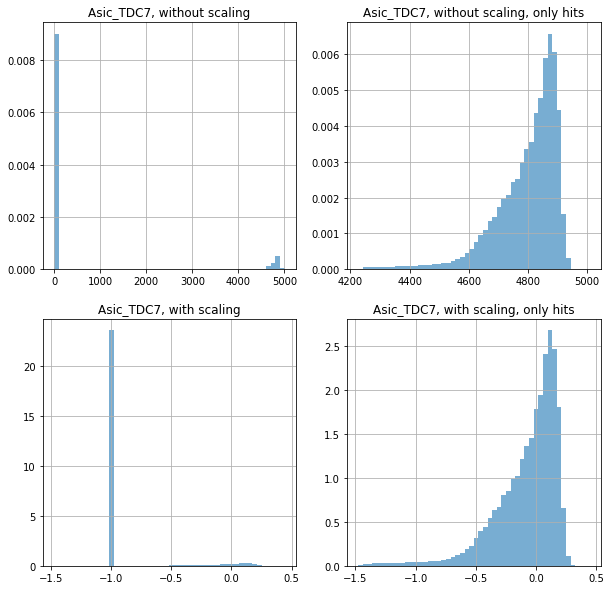

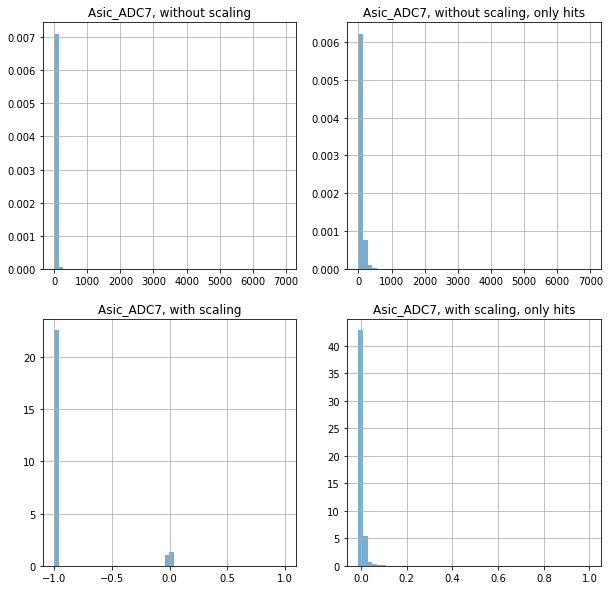

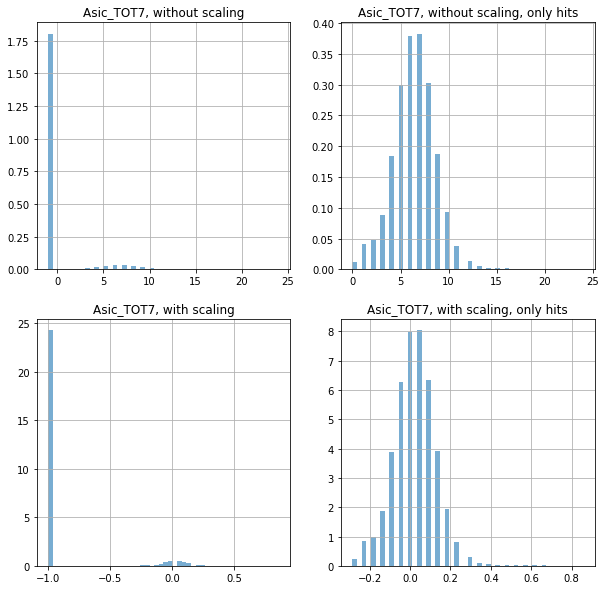

In [8]:
for col in ['Asic_ADC0', 'Asic_TOT0', 'Asic_TDC1', 'Asic_ADC1', 'Asic_TOT1',
            'Asic_TDC2', 'Asic_ADC2', 'Asic_TOT2', 'Asic_TDC3', 'Asic_ADC3',
            'Asic_TOT3', 'Asic_TDC4', 'Asic_ADC4', 'Asic_TOT4', 'Asic_TDC5',
            'Asic_ADC5', 'Asic_TOT5', 'Asic_TDC6', 'Asic_ADC6', 'Asic_TOT6',
            'Asic_TDC7', 'Asic_ADC7', 'Asic_TOT7']:
    plot_ignore(cosmic[col], scaled_cosmic[col], nohit=-1, name=col, bins=50)
    plt.show()



In [9]:
scaled_cosmic.to_csv('../data/processed/cosmic.csv.gz', index=False)

In [10]:
del scaled_cosmic
del cosmic

In [11]:
mc_noct = pd.read_csv('../data/raw/mcmc_noxtalk.csv.gz').drop('Track', axis=1)
mc_noct_scaled = transform(scaler, mc_noct, fit=False)


In [12]:
mc_noct_scaled.to_csv('../data/processed/mcmc_noxtalk.csv.gz', index=False)

In [13]:
del mc_noct
del mc_noct_scaled

In [14]:
mc_ct = pd.read_csv('../data/raw/mcmc_xtalk.csv.gz').drop('Track', axis=1)
mc_ct_scaled = transform(scaler, mc_ct, fit=False)


In [15]:
mc_ct_scaled.to_csv('../data/processed/mcmc_xtalk.csv.gz', index=False)

In [16]:
del mc_ct
del mc_ct_scaled

In [17]:
import pickle 

with open('../saved_models/scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('../saved_models/special_scaler.pickle', 'wb') as f:
    pickle.dump(special_scaler, f)

    